# 모델 설명 SHAP 전 과정
 - 네번째 파이프 라인은 에측 모델로부터 SHAP을 활용하여 모델 BlackBox를 설명하는 '모델 설명 SHAP 과정'입니다.
 - 모델 종류에 구애받지 않고 모델이 유입량을 예측하게 된 이유를 이해하기 위해 SHAP 알고리즘을 선택했습니다.
    
         - 1. SHAP Summary_Plot을 활용하여 예측 모델에 피처 중요도를 확인했습니다.
         - 2. SHAP Force_Plot을 활용하여 예측 모델에 피처의 영향력을 확인했습니다.
         


***

In [1]:
# Data Handling
import pandas as pd
import numpy as np
import joblib

# Visualization
from matplotlib import font_manager, rc
import shap
%matplotlib inline
pd.set_option('max_columns', 20, 'max_rows', 20)

# OS
import os
import warnings; warnings.filterwarnings("ignore")
import pickle
import platform

In [2]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

# 1.Data Load

In [3]:
train = pd.read_csv('../Data/extra_select_train.csv')
test = pd.read_csv('../Data/extra_select_test.csv')
target = pd.read_csv('../Data/target.csv')
sample = pd.read_excel('../Data/홍수ZERO_데이터/02_평가데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_평가데이터_210803.xlsx')
sample = sample.drop(sample.index[0]).drop('NO',axis=1)


In [4]:
print(train.shape)
display(train.head())

print(test.shape)
display(test.head())

print(target.shape)
display(target.head())

(2891, 72)


,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,...,저수량(예년),방수로수위,강우량_해당시간,자체유입,총방류량,강우_0집단,강우_1집단,강우_2집단,강우_3집단,수위_0집단
0,6.4,7.0,7.0,7.0,8.0,2.54,122.56875,6.3,7.0,7.0,...,1093.9,66.74,0.4,143.889,0.00,7.000000,7.0,7.500000,8.000000,2.54
1,6.3,7.0,8.0,7.0,8.0,2.53,122.56250,6.4,7.0,8.0,...,1093.9,69.94,0.9,129.754,560.87,7.000000,8.0,8.500000,9.000000,2.53
2,6.4,7.0,9.0,7.0,8.0,2.53,122.55625,7.3,7.0,9.0,...,1093.9,70.03,0.9,97.138,671.58,7.000000,9.0,8.666667,9.500000,2.53
3,7.3,7.0,10.0,7.0,8.0,2.53,122.55625,8.2,7.0,10.0,...,1093.9,70.13,3.1,268.040,698.04,8.000000,10.0,11.666667,11.333333,2.53
4,8.2,7.0,12.0,8.0,10.0,2.53,122.55625,11.3,9.0,12.0,...,1093.9,70.13,3.1,416.401,703.07,10.166667,12.0,13.666667,13.166667,2.53


(160, 72)


,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,...,저수량(예년),방수로수위,강우량_해당시간,자체유입,총방류량,강우_0집단,강우_1집단,강우_2집단,강우_3집단,수위_0집단
0,14.2576,32,0,0,0,1.93,120.49375,10.9657,32,0,...,884.0,66.86,0.5,131.698,0.31,32.000000,0.0,0.500000,0.000000,1.93
1,10.9657,20,1,0,0,1.93,120.48750,7.9442,20,1,...,884.0,66.85,4.0,394.198,0.31,20.500000,1.0,7.000000,4.000000,1.93
2,7.9442,11,5,0,0,1.92,120.48125,7.8916,12,5,...,884.0,68.56,8.2,274.458,143.07,16.333333,5.0,9.666667,12.000000,1.92
3,7.8916,3,11,0,0,1.92,120.47500,13.3484,13,11,...,884.0,68.86,6.8,51.964,314.74,13.833333,11.0,13.500000,17.833333,1.92
4,13.3484,4,25,1,8,1.92,120.47500,20.0760,18,25,...,884.0,68.96,7.0,68.659,331.16,16.666667,25.0,17.166667,24.666667,1.92


(2891, 1)


,유입량
0,189.100000
1,216.951962
2,251.424419
3,302.812199
4,384.783406


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 72 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   유역평균강수       2891 non-null   float64
 1   강우(A지역)      2891 non-null   float64
 2   강우(B지역)      2891 non-null   float64
 3   강우(C지역)      2891 non-null   float64
 4   강우(D지역)      2891 non-null   float64
 5   수위(E지역)      2891 non-null   float64
 6   수위(D지역)      2891 non-null   float64
 7   유역평균강수.1     2891 non-null   float64
 8   강우(A지역).1    2891 non-null   float64
 9   강우(B지역).1    2891 non-null   float64
 10  강우(C지역).1    2891 non-null   float64
 11  강우(D지역).1    2891 non-null   float64
 12  수위(E지역).1    2891 non-null   float64
 13  수위(D지역).1    2891 non-null   float64
 14  유역평균강수.2     2891 non-null   float64
 15  강우(A지역).2    2891 non-null   float64
 16  강우(B지역).2    2891 non-null   float64
 17  강우(C지역).2    2891 non-null   float64
 18  강우(D지역).2    2891 non-null   float64
 19  수위(E지역

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 72 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   유역평균강수       160 non-null    float64
 1   강우(A지역)      160 non-null    int64  
 2   강우(B지역)      160 non-null    int64  
 3   강우(C지역)      160 non-null    int64  
 4   강우(D지역)      160 non-null    int64  
 5   수위(E지역)      160 non-null    float64
 6   수위(D지역)      160 non-null    float64
 7   유역평균강수.1     160 non-null    float64
 8   강우(A지역).1    160 non-null    int64  
 9   강우(B지역).1    160 non-null    int64  
 10  강우(C지역).1    160 non-null    int64  
 11  강우(D지역).1    160 non-null    int64  
 12  수위(E지역).1    160 non-null    float64
 13  수위(D지역).1    160 non-null    float64
 14  유역평균강수.2     160 non-null    float64
 15  강우(A지역).2    160 non-null    int64  
 16  강우(B지역).2    160 non-null    int64  
 17  강우(C지역).2    160 non-null    int64  
 18  강우(D지역).2    160 non-null    int64  
 19  수위(E지역).

# 2.Load Model

 - Average Ensemble model Load

In [7]:
vr = joblib.load('../Model/Average_Ensemble_2021-09-15_Final.pkl')
vr

VotingRegressor(estimators=(('XGBRegressor',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.5, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=6, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=400, n_jobs=20,
                                          nu...llel_tree=1, random_state=0,
                                          reg_alpha=0, reg_lambda=1,
                                        

In [8]:
xgb = vr.estimators[0][1]
lgb = vr.estimators[1][1]
cat = vr.estimators[2][1]

In [9]:
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=20, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
lgb

LGBMRegressor(colsample_bytree=0.1, max_depth=5, n_estimators=1100,
              num_leaves=33, subsample=0.95)

In [11]:
cat

# 3.SHAP

### XGB

 - 피처가 모델에 미치는 영향력을 알기 위해 SHAP의 TreeExplainer를 통해 Tree model Shap Value 확인, 객체 지정 후 Shap Values 계산을 실행함.

In [12]:
explainer = shap.TreeExplainer(xgb) 
shap_values = explainer.shap_values(test) 

 - javascript를 초기화함 

In [13]:
shap.initjs()

- Shap Values를 기준으로 Summary_plot으로 피처 중요도를 확인하여, 모델에 어떤 피처가 중요한지를 확인함.

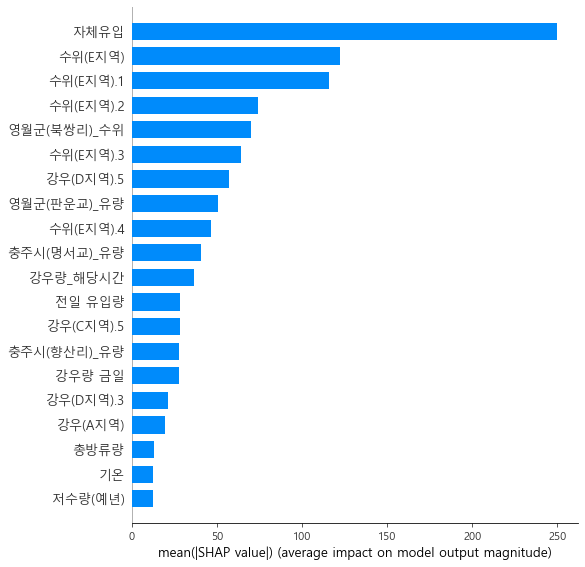

In [14]:
shap.summary_plot(shap_values, test, plot_type = "bar")

- Force_Plot은 각 피처가 예측값을 예측하는데 양의 영향력을 주었는지 음의 영향력을 주었는지 시각화 된 그래프로 빨간색은 양의 
영향력, 파란색은 음의 영향력을 나타내고 이때 그래프에서 x축은 각 피처의 범위 , y축은 각각의 피처에 대한 영향력 값을 나타냄. 

In [15]:
shap.force_plot(explainer.expected_value, shap_values, test) 

- Shap Values를 계산하여 Force_plot으로 피처 영향력을 확인함으로서, 각 피처가 예측값을 에측하는데 어떻게 영향력을 미치는지를 확인함.

### LGB

 - SHAP의 TreeExplainer를 통해 Tree model Shap Value 확인, 객체 지정 후 Shap Values 계산

In [16]:
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(test)

 - javascript를 초기화함 

In [17]:
shap.initjs()

- Shap Values를 기준으로 Summary_plot으로 피처 중요도를 확인하여, 모델에 어떤 피처가 중요한지를 확인함.

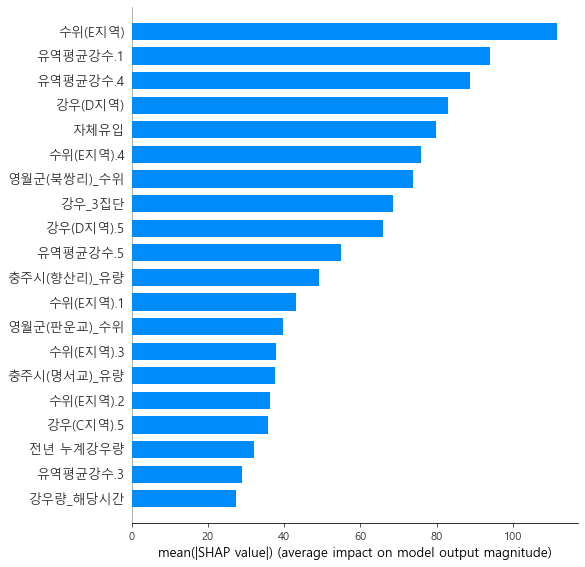

In [18]:
shap.summary_plot(shap_values, test, plot_type = "bar")

- Shap Values를 계산하여 Force_plot으로 피처 영향력을 확인함.

In [19]:
shap.force_plot(explainer.expected_value, shap_values, test) 

### CAT

 - SHAP의 TreeExplainer를 통해 Tree model Shap Value 확인, 객체 지정 후 Shap Values 계산

In [20]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(test)

 - javascript를 초기화함 

In [21]:
shap.initjs()

- Shap Values를 계산하여 Summary_plot으로 피처 중요도를 확인함.

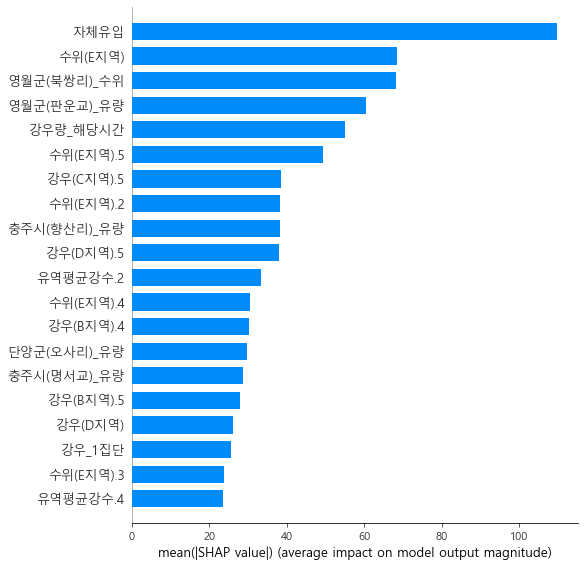

In [22]:
shap.summary_plot(shap_values, test, plot_type = "bar")

- Shap Values를 계산하여 Force_plot으로 피처 영향력을 확인함.

In [23]:
shap.force_plot(explainer.expected_value, shap_values, test) 

# ───────────────── End of Pipeline 4/4  ─────────────────